In [1]:
import mxnet as mx
import numpy as np
import scipy as sp
import sys
import networkx as nx
import igraph as ig
import logging
import time
import matplotlib.pyplot as plt

In [17]:
def get_act(act):
    if (act == 'sigmoid'):
        return sp.special.expit
    elif (act == 'tanh'):
        return np.tanh
    elif (act == 'relu'):
        return lambda x: np.maximum(x, 0)
    else:
        return None
    
weight_names = ['fc1_weight', 'fc2_weight']
bias_names = ['fc1_bias', 'fc2_bias']

def plot_errors(x, y):
    plt.plot(x, y)
    plt.ylabel('error')
    plt.xlabel('epoch')
    plt.show()

class AutoEncoderModel:
    def __init__(self, data, num_dims, internal_act=None, output_act=None, learning_rate=0.005, batch_size=50):
        dims = [data.shape[1], num_dims, data.shape[1]]
        self.data = mx.symbol.Variable('data')
        self.y = mx.symbol.Variable('label')
        self.fc1_weight = mx.symbol.Variable(weight_names[0])
        self.fc1_bias = mx.symbol.Variable(bias_names[0])
        self.fc2_weight = mx.symbol.Variable(weight_names[1])
        self.fc2_bias = mx.symbol.Variable(bias_names[1])
        x = mx.symbol.FullyConnected(data=self.data, weight=self.fc1_weight,
                                     bias=self.fc1_bias, num_hidden=dims[1])
        if (internal_act is not None):
            x = mx.symbol.Activation(data=x, act_type=internal_act)
            print("Internal activation: " + internal_act)
        self.layer1 = x
        x = mx.symbol.FullyConnected(data=x, weight=self.fc2_weight,
                                     bias=self.fc2_bias, num_hidden=dims[2])
        if (output_act is not None):
            x = mx.symbol.Activation(data=x, act_type=output_act)
            print("Output activation: " + output_act)
        self.layer2 = x
        # TODO How about using L1/L2 regularization.
        self.loss = mx.symbol.LinearRegressionOutput(data=x, label=self.y)
        self.model = mx.mod.Module(symbol=self.loss, data_names=['data'], label_names = ['label'])
        self.init_data(data, batch_size, learning_rate)
        
        def cal_model_numpy(params):
            fc1_weight = params.get(weight_names[0]).asnumpy()
            fc1_bias = params.get(bias_names[0]).asnumpy()
            fc2_weight = params.get(weight_names[1]).asnumpy()
            fc2_bias = params.get(bias_names[1]).asnumpy()

            np_data = data.asnumpy()
            hidden = np.dot(np_data, fc1_weight.T) + fc1_bias
            act_func = get_act(internal_act)
            if (act_func is not None):
                hidden = act_func(hidden)
            output = np.dot(hidden, fc2_weight.T) + fc2_bias
            act_func = get_act(output_act)
            if (act_func is not None):
                output = act_func(output)
            return np.sum(np.square(output - np_data))

        self.numpy_cal = cal_model_numpy
        
    def init_data(self, data, batch_size=50, learning_rate=0.005):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':data},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        print("Learning rate: " + str(learning_rate))
        print("batch size: " + str(batch_size))
        # allocate memory given the input data and label shapes
        self.model.bind(data_shapes=data_iter.provide_data, label_shapes=data_iter.provide_label)
        # initialize parameters by uniform random numbers
        self.model.init_params(initializer=mx.init.Uniform(scale=.1))
        # use SGD with learning rate 0.1 to train
        self.model.init_optimizer(optimizer='sgd',
                                  optimizer_params={'learning_rate': learning_rate,
                                                    'momentum': 0.9})

    def fit_int(self, data, batch_size, num_epoch, params=None, learning_rate=0.005, reinit_opt=True):
        data_iter = mx.io.NDArrayIter(data={'data':data}, label={'label':data},
                batch_size=batch_size, shuffle=True,
                last_batch_handle='roll_over')
        
        if (params is not None):
            self.model.set_params(arg_params=params, aux_params=None, force_init=True)
            if (reinit_opt):
                print("reinit optimizer. New learning rate: " + str(learning_rate))
                self.model.init_optimizer(optimizer='sgd',
                                          optimizer_params={'learning_rate': learning_rate,
                                                            'momentum': 0.9}, force_init=True)
        # use accuracy as the metric
        metric = mx.metric.create('acc')
        # train 5 epochs, i.e. going over the data iter one pass
        for epoch in range(num_epoch):
            data_iter.reset()
            metric.reset()
            for batch in data_iter:
                self.model.forward(batch, is_train=True)       # compute predictions
                self.model.update_metric(metric, batch.label)  # accumulate prediction accuracy
                self.model.backward()                          # compute gradients
                self.model.update()                            # update parameters
            #print('Epoch %d, Training %s' % (epoch, metric.get()))

    def train(self, data, num_epoc, params = None, debug=False, return_err=False):
        print("internal #epochs: " + str(num_epoc))
        int_epoc = 100
        prev_val = None
        reinit_opt = True
        plot_xs = []
        plot_yx = []
        for i in range(num_epoc/int_epoc):
            curr = time.time()
            self.fit_int(data, self.batch_size, int_epoc, params, self.learning_rate, reinit_opt=reinit_opt)
            if (debug):
                print(str(int_epoc) + " epochs takes " + str(time.time() - curr) + " seconds")
            reinit_opt = False

            params = self.model.get_params()[0]
            val = self.numpy_cal(params)
            plot_xs.append((i + 1) * int_epoc)
            plot_yx.append(val)
            if (debug):
                print("epoc " + str((i + 1) * int_epoc) + ": " + str(val))
                sys.stdout.flush()
            if (prev_val is not None and prev_val < val):
                self.learning_rate = self.learning_rate / 2
                reinit_opt = True
            prev_val = val
        plot_errors(plot_xs, plot_yx)
        if (return_err):
            return params, plot_xs, plot_yx
        else:
            return params

In [18]:
def train(data, num_dims, num_epoc, internal_act=None, output_act=None, learning_rate=0.005, batch_size=50, debug=False, return_err=False):
    model = AutoEncoderModel(data, num_dims, internal_act, output_act, learning_rate, batch_size)
    return model.train(data, num_epoc, debug=debug, return_err=return_err)

## Run on a low-rank data

In [19]:
rand_data1 = mx.ndarray.random_uniform(shape=[1000, 10])
rand_data2 = mx.ndarray.random_uniform(shape=[10, 100])
rand_data = mx.ndarray.dot(rand_data1, rand_data2)
print("max: " + str(mx.ndarray.max(rand_data)))
rand_data = rand_data / mx.ndarray.max(rand_data)
print(rand_data.shape)

max: 
[ 5.49624777]
<NDArray 1 @cpu(0)>
(1000L, 100L)


In [20]:
np_rand_data = rand_data.asnumpy()
U, s, Vh = sp.sparse.linalg.svds(np_rand_data, k=10)
low_dim_data = np.dot(np_rand_data, Vh.T)
print(low_dim_data)
print(sum(low_dim_data[low_dim_data > 0]))
print(sum(low_dim_data[low_dim_data < 0]))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_rand_data))))

[[-0.06789682  0.11745708  0.01811091 ..., -0.22041818  0.25947556
   4.58424139]
 [ 0.06577194  0.15134373  0.12103066 ...,  0.09472218  0.52994013
   4.72747707]
 [ 0.18843757 -0.02188844  0.01198309 ..., -0.19646543  0.0452216
   3.51541185]
 ..., 
 [ 0.14157917  0.11198635 -0.05527457 ..., -0.25732851  0.19383214
   4.35923386]
 [ 0.04307616 -0.11992847 -0.01043215 ..., -0.1986502  -0.17690027
   5.00072002]
 [-0.03079219  0.05760233 -0.08055174 ...,  0.09610062 -0.04332777
   3.86204791]]
5186.59034291
-553.564527681
svd error: 1.31856e-08


Learning rate: 0.4
batch size: 100
internal #epochs: 5000


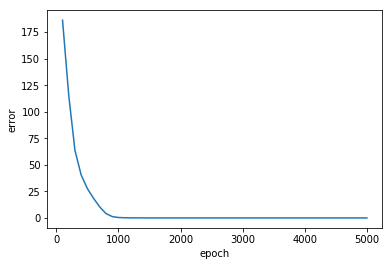

In [21]:
params_linear_r10=train(rand_data, 10, 5000, learning_rate=0.4, batch_size=100)

Internal activation: tanh
Learning rate: 0.4
batch size: 100
internal #epochs: 5000
reinit optimizer. New learning rate: 0.2
reinit optimizer. New learning rate: 0.1
reinit optimizer. New learning rate: 0.05


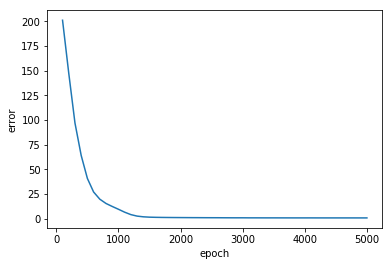

In [22]:
params_sigmoid_r10=train(rand_data, 10, 5000, internal_act='tanh', learning_rate=0.4, batch_size=100)

## Run on real data

We compute the embedding on a graph with 81306 vertices and 1768149 vertices. To embed the graph into 10 dimensions, we start with the most densest columns and increase the number of columns to embed. When we increase the number of columns to embed, we use the parameters trained from the previous run (on the dataset with a smaller number of columns).

In [23]:
elg = nx.read_edgelist("/home/ubuntu/datasets/twitter_combined.txt")
spm = nx.to_scipy_sparse_matrix(elg, dtype='f')

In [24]:
def get_densest_idx(spm, num):
    colsum = np.ravel(spm.sum(axis=0))
    max_cols = np.sort(np.ravel(colsum), axis=None)[len(colsum) - num]
    return max_cols, colsum >= max_cols

def get_densest(spm, num):
    max_cols, idx = get_densest_idx(spm, num)
    sp_data = spm[:,idx]
    return sp_data

def get_densest2(spm, num1, num2):
    colsum = np.ravel(spm.sum(axis=1))
    sorted_colsum = np.sort(np.ravel(colsum), axis=None)
    max_cols1 = sorted_colsum[len(colsum) - num1]
    max_cols2 = sorted_colsum[len(colsum) - (num2 + num1)]
    sp_data1 = spm[:,colsum >= max_cols1]
    sp_data2 = spm[:,np.logical_and(colsum >= max_cols2, colsum < max_cols1)]
    return sp_data1, sp_data2

### Compute the embedding on the densest 10 columns.

In [25]:
sp_data10 = get_densest(spm, 10)
data10 = mx.ndarray.sparse.csr_matrix(sp_data10)
print(mx.ndarray.sum(data10, axis=0))
print(data10.shape)


[ 2490.  3383.  2484.  2758.  2476.  1789.  2133.  3011.  3239.  2155.]
<NDArray 10 @cpu(0)>
(81306L, 10L)


In [26]:
np_data10 = data10.asnumpy()
U, s, Vh = sp.linalg.svd(np_data10, full_matrices=False)
low_dim_data = np.dot(np_data10, Vh.T)
print(low_dim_data.shape)
print(np.max(low_dim_data))
print(np.min(low_dim_data))
res = np.dot(low_dim_data, Vh)
print("svd error: " + str(np.sum(np.square(res - np_data10))))

(81306, 10)
1.21314
-2.3992
svd error: 6.78263e-09


Learning rate: 0.1
batch size: 2000
internal #epochs: 2000


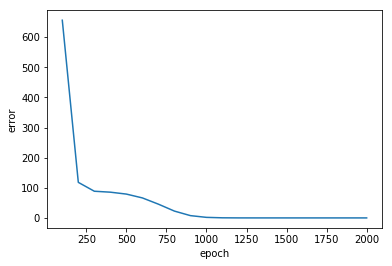

In [27]:
params_linear10=train(data10, 10, 2000, internal_act=None, learning_rate=0.1, batch_size=2000)

Internal activation: tanh
Learning rate: 0.1
batch size: 2000
internal #epochs: 10000


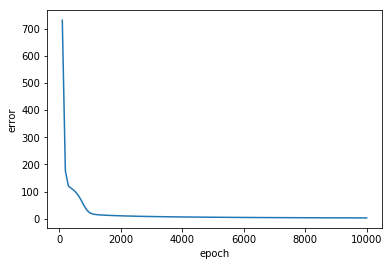

In [28]:
params_sigmoid10=train(data10, 10, 10000, internal_act='tanh', learning_rate=0.1, batch_size=2000)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 10000


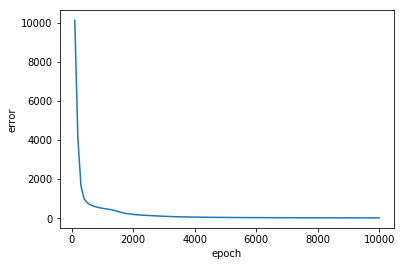

In [29]:
params_sigmoid10=train(data10, 10, 10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

### Compute the embedding on the densest 30 columns

In [30]:
sp_data30 = get_densest(spm, 30)
data30 = mx.ndarray.sparse.csr_matrix(sp_data30)
print(mx.ndarray.sum(data30, axis=0))
print(data30.shape)


[ 1256.  1377.  1467.  1251.  1521.  1229.  2490.  1695.  1291.  1387.
  1275.  1743.  1443.  1497.  3383.  2484.  2758.  1666.  1255.  2476.
  1789.  1358.  1269.  1395.  2133.  3011.  3239.  1568.  2155.  1509.]
<NDArray 30 @cpu(0)>
(81306L, 30L)


In [31]:
U, s, Vh = sp.sparse.linalg.svds(sp_data30, k=15)
res = np.dot(sp_data30.dot(Vh.T), Vh)
print("svd error: " + str(np.sum(np.square(res - sp_data30))))

svd error: 12539.0


Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 5000


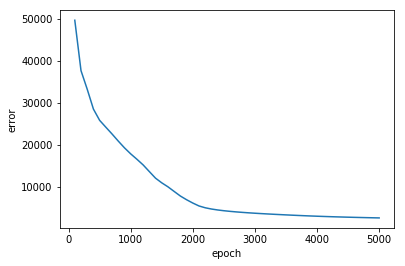

In [32]:
params_sigmoid30=train(data30, num_dims=15, num_epoc=5000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

### Compute the embedding on the densest 100 columns.

In [33]:
sp_data100 = get_densest(spm, 100)
data100 = mx.ndarray.sparse.csr_matrix(sp_data100)
print(mx.ndarray.sum(data100, axis=0))
print(data100.shape)


[ 1256.   923.  1180.   802.   979.   744.   948.   837.  1377.  1183.
  1023.  1467.   748.  1251.  1198.   921.   818.   777.   889.  1185.
  1521.   744.  1229.   916.   810.   804.   844.  1051.   861.   991.
   784.  1225.  2490.   975.   915.   996.  1030.   822.   806.   756.
  1695.   780.  1053.   964.  1291.  1103.  1091.  1387.  1275.   889.
   828.  1743.  1443.   959.  1497.  3383.   798.   756.  1080.   937.
   758.  2484.   879.   849.   766.   737.  2758.   733.   788.   878.
  1666.   857.  1079.   902.   783.  1255.  2476.   780.  1789.  1054.
   932.  1358.  1269.  1161.   765.   912.   818.  1220.  1395.  1009.
   801.  2133.  3011.  3239.  1568.  2155.  1072.  1509.  1226.   779.]
<NDArray 100 @cpu(0)>
(81306L, 100L)


We want to start with SVD and see how well it performs.

In [34]:
U, s, Vh = sp.sparse.linalg.svds(sp_data100, k=30)
res = np.dot(sp_data100.dot(Vh.T), Vh)
print("svd error: " + str(np.sum(np.square(res - sp_data100))))

svd error: 42371.5


With curriculum learning, we can take advantage of the computation results from the denser columns.
To some extent, curriculum learning provides a new way of initializing the parameters of a neural network. We take the parameters from the neural network trained for the denser columns of a graph to initialize the neural network for the dataset with more columns.

The functions below expand and shrink the weight matrices for the smaller or the larger neural networks.

In [35]:
# Extend the weight matrices in the encoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_encode(weight, bias, idx, num_inputs, num_outputs, rand_init):
    if (rand_init):
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    else:
        out_weight = np.zeros((num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[0:weight.shape[0], idx] = weight.asnumpy()
    out_bias[0:bias.shape[0]] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Extend the weight matrices in the decoder of the smaller autoencoder to
# the shape required by the larger autoencoder.
def extend_params_decode(weight, bias, idx, num_inputs, num_outputs, rand_init):
    if (rand_init):
        # We initialize the weights in the same way as MXNet
        out_weight = np.random.uniform(low=-0.1, high=0.1, size=(num_outputs, num_inputs))
    else:
        out_weight = np.zeros((num_outputs, num_inputs))
    out_bias = np.zeros(num_outputs)
    out_weight[idx, 0:weight.shape[1]] = weight.asnumpy()
    out_bias[idx] = bias.asnumpy()
    return mx.nd.array(out_weight), mx.nd.array(out_bias)

# Shrink the weight matrices in the encoder of the larger autoencoder to
# the shape required by the smaller autoencoder. This operation is
# the reverse of extend_params_encode.
def shrink_params_encode(weight, bias, idx, num_inputs, num_outputs):
    weight = weight.asnumpy()
    bias = bias.asnumpy()
    return mx.nd.array(weight[0:num_outputs, idx]), mx.nd.array(bias[0:num_outputs])

# Shrink the weight matrices in the decoder of the larger autoencoder to
# the shape required by the smaller autoencoder. This operation is
# the reverse of extend_params_decode.
def shrink_params_decode(weight, bias, idx, num_inputs, num_outputs):
    weight = weight.asnumpy()
    bias = bias.asnumpy()
    return mx.nd.array(weight[idx, 0:num_inputs]), mx.nd.array(bias[idx])

# This function extends the parameter matrices in the small autoencoder
# to an autoencoder with the specified number of input nodes and hidden nodes.
def extend_params(params, new_data, new_hidden, rand_init=False):
    old_inputs = params.get(weight_names[0]).shape[1]
    old_hidden = params.get(bias_names[0]).shape[0]
    new_inputs = new_data.shape[1]
    max_cols, max_idx = get_densest_idx(new_data, old_inputs)
    weight, bias = extend_params_encode(params.get(weight_names[0]),
                                        params.get(bias_names[0]), max_idx,
                                        new_inputs, new_hidden, rand_init)
    new_params = {}
    new_params.update({weight_names[0]: weight})
    new_params.update({bias_names[0]: bias})
    weight, bias = extend_params_decode(params.get(weight_names[1]),
                                        params.get(bias_names[1]), max_idx,
                                        new_hidden, new_inputs, rand_init)
    new_params.update({weight_names[1]: weight})
    new_params.update({bias_names[1]: bias})
    return new_params

The code in this section is to verify the implementation of the functions above work correctly.

In [ ]:
def cal_model_numpy(data, params, selected_cols=None, internal_act=None, output_act=None):
    fc1_weight = params.get(weight_names[0]).asnumpy()
    fc1_bias = params.get(bias_names[0]).asnumpy()
    fc2_weight = params.get(weight_names[1]).asnumpy()
    fc2_bias = params.get(bias_names[1]).asnumpy()

    np_data = data.asnumpy()
    hidden = np.dot(np_data, fc1_weight.T) + fc1_bias
    act_func = get_act(internal_act)
    if (act_func is not None):
        hidden = act_func(hidden)
    output = np.dot(hidden, fc2_weight.T) + fc2_bias
    act_func = get_act(output_act)
    if (act_func is not None):
        output = act_func(output)
    if (selected_cols is None):
        return np.sum(np.square(output - np_data))
    else:
        return np.sum(np.square(output[:,selected_cols] - np_data[:,selected_cols]))

tmp30 = params_sigmoid30
tmp100 = extend_params(tmp30, sp_data100, 30, rand_init=False)
max_cols30, max_idx30 = get_densest_idx(sp_data100, 30)
print(cal_model_numpy(data30, tmp30, internal_act='tanh', output_act='sigmoid'))
print(cal_model_numpy(data100, tmp100, selected_cols=max_idx30, internal_act='tanh', output_act='sigmoid'))

2551.12
2551.12


Here we use the parameters from the smaller autoencoder to initialize the parameters in the larger autoencoder.

In [ ]:
params_sigmoid100_init = extend_params(params_sigmoid30, sp_data100, 30, rand_init=True)
model = AutoEncoderModel(data100, 30, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)
params_sigmoid100 = model.train(data100, num_epoc=5000, params=params_sigmoid100_init)

Internal activation: tanh
Output activation: sigmoid
Learning rate: 0.2
batch size: 2000
internal #epochs: 5000
reinit optimizer. New learning rate: 0.2


In [ ]:
params_sigmoid100_2 = model.train(data100, num_epoc=5000, params=params_sigmoid100)

In [ ]:
params_sigmoid100_orig=train(data100, num_dims=30, num_epoc=10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

### Compute the embedding on the densest 1000 columns.

In [ ]:
sp_data1000 = get_densest(spm, 1000)
data1000 = mx.ndarray.sparse.csr_matrix(sp_data1000)
print(mx.ndarray.sum(data1000, axis=0))
print(data1000.shape)

In [ ]:
U, s, Vh = sp.sparse.linalg.svds(sp_data1000, k=100)
res = np.dot(sp_data1000.dot(Vh.T), Vh)
print("svd error: " + str(np.sum(np.square(res - sp_data1000))))

In [ ]:
params_sigmoid1000_init = extend_params(params_sigmoid100, sp_data1000, 100, rand_init=True)
model = AutoEncoderModel(data1000, num_dims=100, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)
params_sigmoid1000 = model.train(data1000, num_epoc=10000, params=params_sigmoid1000_init)

In [ ]:
params_sigmoid1000=train(data1000, num_dims=100, num_epoc=10000, internal_act='tanh', output_act='sigmoid', learning_rate=0.2, batch_size=2000)

In [ ]:
data1000 = mx.ndarray.sparse.csr_matrix(sp_data1000)
print(mx.ndarray.sum(data1000, axis=0))
print(data1000.shape)

In [ ]:
pref_matrix = [[0.9, 0.1], [0.1, 0.9]]
block_sizes = [70, 30]
g = ig.Graph.SBM(100, pref_matrix, block_sizes, directed=True)
sim_spm = g.get_adjacency()